In [1]:
import numpy as np
import xarray as xr
from scipy.signal import medfilt
from scipy.interpolate import interp1d

In [2]:
def clean_spectrum(spec, spec_err):
    """
    Cleans a 1D spectrum by identifying outliers with a median filter
    and interpolating over them.
    """
    # Use a wider median filter to get a smoother, more robust baseline
    kernel_size_baseline = 15
    spec_filt = medfilt(spec, kernel_size=kernel_size_baseline)
    
    # Use a smaller sigma_thresh for more aggressive clipping
    sigma_thresh = 3
    bad_pix_mask = np.abs(spec - spec_filt) > sigma_thresh * spec_err
    
    if not bad_pix_mask.any():
        return spec
    
    good_pix_indices = np.arange(len(spec))[~bad_pix_mask]
    
    if len(good_pix_indices) < 2:
        return np.full_like(spec, np.nan)
    
    interp_func = interp1d(good_pix_indices, 
                           spec[good_pix_indices], 
                           kind='cubic', 
                           fill_value='extrapolate')
    
    cleaned_spec = spec.copy()
    cleaned_spec[bad_pix_mask] = interp_func(np.arange(len(spec))[bad_pix_mask])
    
    return cleaned_spec

def update_errors(spec_err, bad_pix_mask):
    """
    Updates the error array, setting the error of bad pixels to infinity.
    """
    updated_err = spec_err.copy()
    updated_err[bad_pix_mask] = np.inf
    return updated_err

In [16]:
original_dataset = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/combined_blue_spectra.nc")

# Select the flux and error DataArrays
xr_spectra = original_dataset['flux_calibrated']
xr_errors = original_dataset['flux_calibrated_error']

# Apply the cleaning function to the flux data
cleaned_spectra = xr.apply_ufunc(
    clean_spectrum,
    xr_spectra,
    xr_errors,
    input_core_dims=[['wavelength'], ['wavelength']],
    output_core_dims=[['wavelength']],
    vectorize=True,
    output_dtypes=[xr_spectra.dtype]
)

# Apply the cleaning function to get the bad pixel mask
spec_filt = xr.apply_ufunc(
    medfilt,
    xr_spectra,
    input_core_dims=[['wavelength']],
    output_core_dims=[['wavelength']],
    kwargs={'kernel_size': 7},
    vectorize=True
)
bad_pix_mask = np.abs(xr_spectra - spec_filt) > 3 * xr_errors

# Apply the error update function using the bad pixel mask
updated_errors = xr.apply_ufunc(
    update_errors,
    xr_errors,
    bad_pix_mask,
    input_core_dims=[['wavelength'], ['wavelength']],
    output_core_dims=[['wavelength']],
    vectorize=True
)

In [17]:
# Create a copy of the original dataset to preserve all other variables
final_dataset = original_dataset.copy()

# Wide-kernel smoothing for the broad noise
smoothing_kernel_size = 1 # Use an odd number
smoothed_spectra = xr.apply_ufunc(
    medfilt,
    cleaned_spectra,
    input_core_dims=[['wavelength']],
    output_core_dims=[['wavelength']],
    kwargs={'kernel_size': smoothing_kernel_size},
    vectorize=True
)

# Update the final dataset with the smoothed, corrected data
final_dataset = original_dataset.copy()
final_dataset['flux_calibrated'] = cleaned_spectra


final_dataset['flux_calibrated_error'] = updated_errors

# Clip the entire dataset to only wavelengths < 5600
    # Note this is because there's instrumental noise that can't be cleane without affecting spectral features too.
#final_clipped_dataset = final_dataset.sel(wavelength=final_dataset.wavelength < 5600)

# Save the final clipped dataset to a new file
output_file_path = "D:/Pavlicek, Emma/SDSS1411/blue.nc"
final_dataset.to_netcdf(output_file_path)


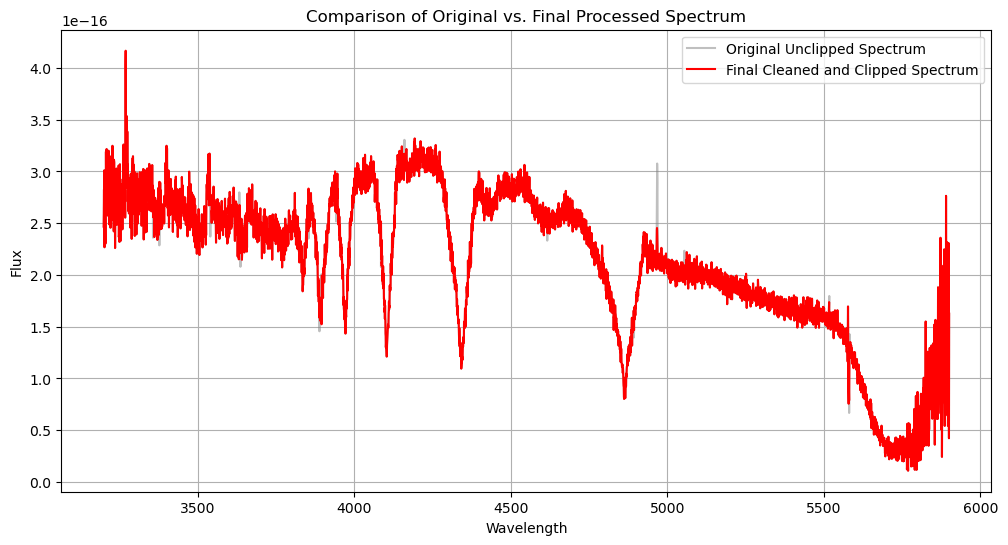

In [18]:
import matplotlib.pyplot as plt

# --- Plotting to show the result ---
# Select the first spectrum from the final, clipped dataset
final_spectrum = final_dataset['flux_calibrated'].isel(time=0)
original_spectrum = original_dataset['flux_calibrated'].isel(time=0)

plt.figure(figsize=(12, 6))

# Plot the original, un-clipped spectrum for comparison
plt.plot(original_spectrum.wavelength, original_spectrum.values, 
         label='Original Unclipped Spectrum', alpha=0.5, color='gray')

# Plot the final, cleaned, and clipped spectrum
plt.plot(final_spectrum.wavelength, final_spectrum.values, 
         label='Final Cleaned and Clipped Spectrum', color='red')

plt.title('Comparison of Original vs. Final Processed Spectrum')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.grid(True)
plt.show()